In [1]:
import gym
from gym import spaces
from rljax.algorithm import DQN
from rljax.trainer import Trainer
import numpy as np
import pandas as pd

from environment import Env

In [2]:
data = pd.read_csv("SH_SDS_data_4.csv", index_col=0)
data.current_state = [('000'+str(cs))[-3:] for cs in data.current_state]
prob = pd.read_csv("SH_SDS_transition_matrix.csv", index_col=0)
prob.index = [('000'+str(idx))[-3:] for idx in prob.index]

In [3]:
# 23,400 seconds between 9:30am and 4pm broken in 10 second increments
# Stepping through 50,000 trading days

NUM_AGENT_STEPS = 50000
SEED = 0

env = Env(data, prob, steps=2340)
env_test = Env(data, prob,steps=2340)

algo = DQN(
    num_agent_steps=NUM_AGENT_STEPS,
    state_space=env.state_space,
    action_space=env.action_space,
    seed=SEED,
    batch_size=256,
    start_steps=1000,
    update_interval=1,
    update_interval_target=400,
    eps_decay_steps=0,
    loss_type="l2",
    lr=1e-3,
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    log_dir="",
    num_agent_steps=NUM_AGENT_STEPS,
    eval_interval=1000,
    seed=SEED,
)
trainer.train()

Num steps: 1000     Return: -173706.4   Time: 0:00:33
Num steps: 2000     Return: -1759.7   Time: 0:01:07
Num steps: 3000     Return: -1494.4   Time: 0:01:42
Num steps: 4000     Return: -4762.1   Time: 0:02:16
Num steps: 5000     Return: -756.3   Time: 0:02:52
Num steps: 6000     Return: -4024.9   Time: 0:03:26
Num steps: 7000     Return: -4290.8   Time: 0:04:00
Num steps: 8000     Return: -5817.5   Time: 0:04:35
Num steps: 9000     Return: -1646.8   Time: 0:05:09
Num steps: 10000    Return: -3451.6   Time: 0:05:44
Num steps: 11000    Return: 1632.9   Time: 0:06:18
Num steps: 12000    Return: -4136.5   Time: 0:06:53
Num steps: 13000    Return: -31733.7   Time: 0:07:27
Num steps: 14000    Return: -16656.0   Time: 0:08:01
Num steps: 15000    Return: -31904.2   Time: 0:08:36
Num steps: 16000    Return: 234.9   Time: 0:09:11
Num steps: 17000    Return: -20597.7   Time: 0:09:46
Num steps: 18000    Return: 16962.6   Time: 0:10:20
Num steps: 19000    Return: -17409.1   Time: 0:10:55
Num steps

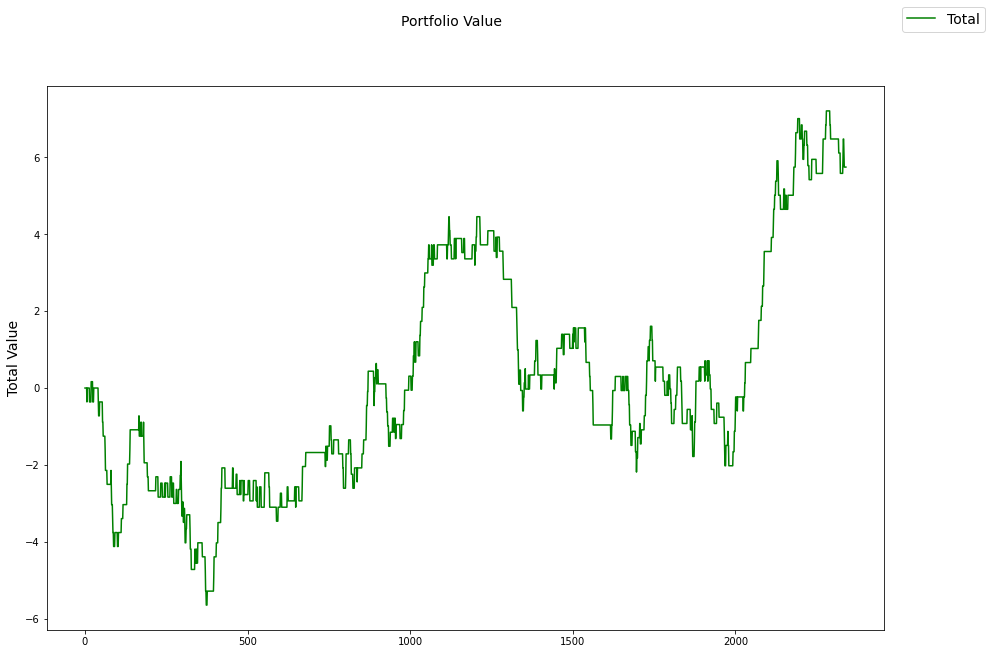

In [4]:
env.plot()

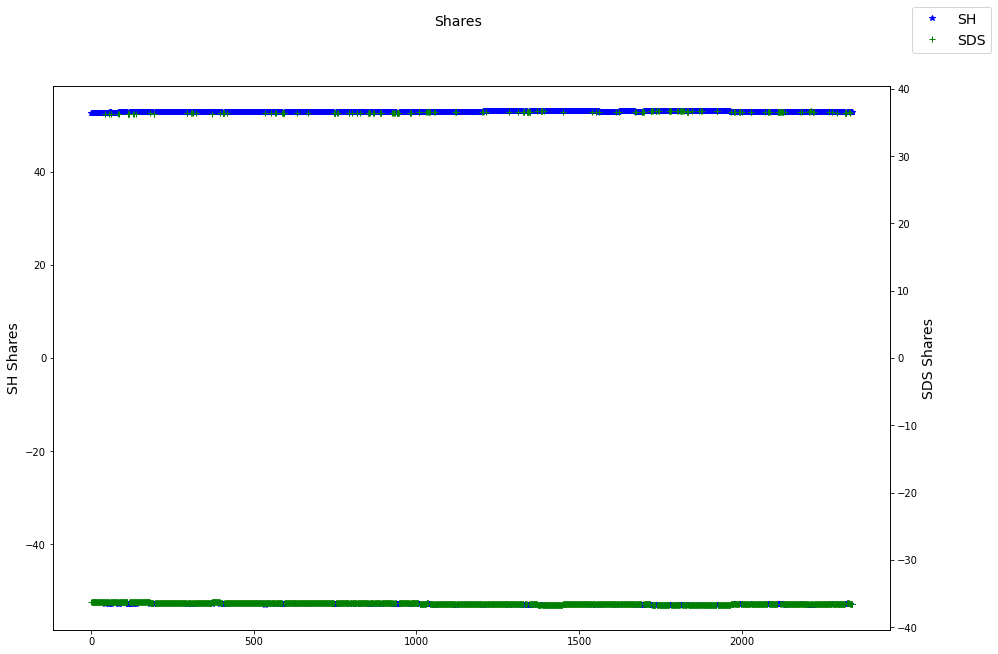

In [5]:
env.plot('share_history')